## Assignment 2 - Exploration of patterns in the data

### Energy Demand based on time data

Energy Demand (Regression): Heavily dependant on seasonal patterns (time-of-day, day-of-week, time-of-year), and partly on weather

Descriptive model : Model the relationship between time and demand
Predictive model : Since predicting the time as a given time in the future is trivial, this is almost for free. Different types include Long-term Load Forecasting (months-ahead), Short-term Load Forecasting (day-head or week-ahead), and Ultra Short-term Load Forecasting (hours-ahead).

In [ ]:
I have decided explore demand as a function of time features. I will first look at the 

In [3]:
# import what has to be
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# create client
client = InfluxDBClient(host = 'influxus.itu.dk', port = 8086, username = 'lsda', password = 'icanonlyread')
client.switch_database('orkney')

In [28]:
client.get_list_measurements()

[{'name': 'ANM_Operation'},
 {'name': 'Demand'},
 {'name': 'Generation'},
 {'name': 'Generator_Site_Issues'},
 {'name': 'SHEPD_Equipment'},
 {'name': 'Temperature'},
 {'name': 'Wind'}]

In [25]:
# get demand data for exploration
results = client.query('SELECT Total FROM "Demand" WHERE time > now() - 200w')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_df = pd.DataFrame(values, columns = columns).set_index("time")

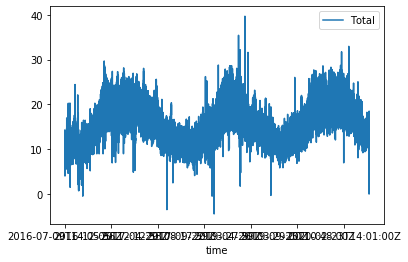

In [26]:
demand_df.plot()

In [17]:
demand_df.head()

,Total
time,
2016-07-09T13:42:56Z,7.96
2016-07-09T13:43:56Z,7.96
2016-07-09T13:44:56Z,7.96
2016-07-09T13:46:56Z,6.69
2016-07-09T13:47:56Z,7.22


In [12]:
results = client.query('SELECT * FROM "Generation" where time > now() - 4w ORDER BY time')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
#generation_df = pd.DataFrame(values, columns = columns).set_index("time")

In [13]:
generation_df.head()

,ANM,Non-ANM,Total
time,,,
2020-03-26T08:13:00Z,1.850000,5.671,7.521000
2020-03-26T08:14:00Z,1.814000,5.359,7.173000
2020-03-26T08:15:00Z,1.669000,5.390,7.059000
2020-03-26T08:16:00Z,1.738000,5.347,7.085000
2020-03-26T08:17:00Z,2.048999,5.007,7.055999


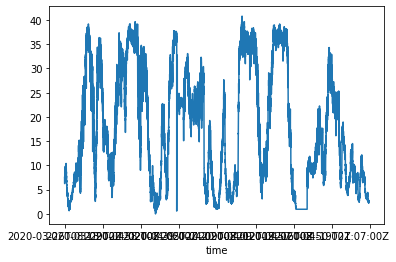

In [7]:
generation_df['Total'].plot()

In [26]:
results = client.query('SELECT * FROM "Temperature" where time > now() - 3w ORDER BY time')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
temperature_df = pd.DataFrame(values, columns = columns).set_index("time")

In [27]:
temperature_df.head()

,Celsius,latitude,longitude
time,,,
2020-02-03T21:00:00Z,7.864709,59,356.75
2020-02-04T00:00:00Z,7.846277,59,356.75
2020-02-04T03:00:00Z,7.854883,59,356.75
2020-02-04T06:00:00Z,7.601282,59,356.75
2020-02-04T09:00:00Z,7.507898,59,356.75


In [28]:
results = client.query('SELECT * FROM "Wind" where time > now() - 3w ORDER BY time')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
wind_df = pd.DataFrame(values, columns = columns).set_index("time")

In [29]:
wind_df.head()

,M/S,height,latitude,longitude,u,v
time,,,,,,
2020-02-03T21:00:00Z,22.344075,10.0,59,356.75,22.294544,1.486936
2020-02-03T21:00:00Z,26.071696,80.0,59,356.75,26.045889,1.159734
2020-02-04T00:00:00Z,9.621333,10.0,59,356.75,1.649443,-9.478891
2020-02-04T00:00:00Z,11.310281,80.0,59,356.75,1.662510,-11.187427
2020-02-04T03:00:00Z,13.995145,10.0,59,356.75,-0.550066,-13.984331


In [30]:
results = client.query('SELECT * FROM "ANM_Operation" where time > now() - 3w ORDER BY time')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
anm_df = pd.DataFrame(values, columns = columns).set_index("time")

In [31]:
anm_df.head()

,Core Zone,Zone 1,Zone 1A,Zone 2,Zone 2A,Zone 2B,Zone 3,Zone 4,Zone 4A
time,,,,,,,,,
2020-02-03T19:03:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03T19:04:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03T19:05:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03T19:06:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03T19:07:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# working on generation dataset
generation_df = generation_df.reset_index()

In [20]:
from datetime import datetime, timedelta

In [24]:
generation_df['datetime'] = generation_df['time'].apply(lambda x: datetime.strptime(x[:-1], '%Y-%m-%dT%H:%M:%S'))

0       2020-03-26 08:13:00
1       2020-03-26 08:14:00
2       2020-03-26 08:15:00
3       2020-03-26 08:16:00
4       2020-03-26 08:17:00
                ...        
39834   2020-04-23 08:08:00
39835   2020-04-23 08:09:00
39836   2020-04-23 08:10:00
39837   2020-04-23 08:11:00
39838   2020-04-23 08:12:00
Name: time, Length: 39839, dtype: datetime64[ns]

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

In [29]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        None
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        return X

In [31]:
dateTransformer = DateTransformer()
transformed = dateTransformer.fit_transform(X = generation_df)

In [32]:
print(transformed)

time       ANM  Non-ANM     Total
0      2020-03-26T08:13:00Z  1.850000    5.671  7.521000
1      2020-03-26T08:14:00Z  1.814000    5.359  7.173000
2      2020-03-26T08:15:00Z  1.669000    5.390  7.059000
3      2020-03-26T08:16:00Z  1.738000    5.347  7.085000
4      2020-03-26T08:17:00Z  2.048999    5.007  7.055999
...                     ...       ...      ...       ...
39834  2020-04-23T08:08:00Z  0.427000    2.120  2.547000
39835  2020-04-23T08:09:00Z  0.385000    2.060  2.445000
39836  2020-04-23T08:10:00Z  0.346000    1.931  2.277000
39837  2020-04-23T08:11:00Z  0.368000    1.951  2.319000
39838  2020-04-23T08:12:00Z  0.410000    2.135  2.545000

[39839 rows x 4 columns]
